# Modèle de détection de faux billets

**Contexte :** L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM, est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, elle souhaite mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

**Objectif :** Construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

**Méthodologie :** Nous disposons actuellement de six informations géométriques sur un billet :

● length : la longueur du billet (en mm) ; </br>
● height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;</br>
● height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;</br>
● margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;</br>
● margin_low : la marge entre le bord inférieur du billet et l'image decelui-ci (en mm) ;</br>
● diagonal : la diagonale du billet (en mm).</br>
                    
Ces informations sont celles avec lesquelles l’algorithme devra opérer.

## Import des librairies

In [185]:
import json
import warnings
from os import listdir
from os.path import isfile, join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from skimpy import skim
from functions import *
from scipy.stats import t, shapiro, kruskal

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from statsmodels.compat import lzip
from statsmodels.graphics.regressionplots import plot_partregress_grid, plot_fit

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import f1_score

In [186]:
#Versions utilisées

print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Seaborn : " + str(sns.__version__))

Pandas : 2.2.0
Numpy : 1.25.0
Seaborn : 0.13.2


## Setup

In [187]:
# No warnings
warnings.filterwarnings("ignore")

## 1. First tour

In [188]:
# import des fichiers
df = pd.read_csv(
    r"../data/billets.csv",
    sep=";"
    )

billets_test = pd.read_csv(
    r"../data/billets_test.csv"
    )

In [189]:
df.shape

(1500, 7)

In [190]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [192]:
# alternative à describe() :

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1500   │ │ float64     │ 6     │                                                          │
│ │ Number of columns │ 7      │ │ bool        │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ diagonal           │    0 │       0 │     170 │    0.31 │   170 │   170 │   170 │   170 │    170 │  ▁▃▇▆▂  │  │
│ │ height_left        │    0 │       0 │     100 │     0.3 │   100 │   100 │   100 │   100 │    100 │ ▁▃▇▇▃▁  │  │
│ │ height_right       │    0 │       0 │     100 │    0.33 │   100 │   100 │   100 │   100 │    100 │   ▂▇▇▃  │  │
│ │ margin_low         │   37 │    2.47 │     4.5 │    0.66 │     3 │     4 │   4.3 │   4.9 │    6.9 │  ▁▇▅▃▁  │  │
│ │ margin_up          │    0 │       0 │     3.2 │    0.23 │   2.3 │     3 │   3.1 │   3.3 │    3.9 │   ▁▇▇▃  │  │
│ │ length             │    0 │       0 │     110 │    0.87 │   110 │   110 │   110 │   110 │    110 │  ▁▃▃▇▁  │  │
│ └────────────────────┴──────┴─────────┴─────────┴─────────┴───────┴───────┴───────┴───────┴────────┴─────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ true            ┃ true rate                     ┃ hist                ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ is_genuine                         │            1000 │                          0.67 │       ▅    ▇        │  │
│ └────────────────────────────────────┴─────────────────┴───────────────────────────────┴─────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

On a :
- 1500 individus
- 7 variables au total :
    - float : 6 variables qui sont des caractéristiques du billet (hauteur droite et gauche, marges haute et basse, largeur, et diagonale)
    - booleen : 1 variable qui nous indique si le billet est faux ou vrai. On à 1000 valeurs "True" et 500 valeurs "False".

On remarque que la variable "margin_low" contient 37 valeurs manquantes, qui représentent 2.47% de notre jeu de données.

## 2. Data Cleaning

### NaN

In [193]:
missing_values = df.isnull().sum()

missing_values

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [194]:
# stockage des index avec des valeurs manquantes pour des futures vérifications

index_nan = df[df['margin_low'].isna()].index

In [195]:
# définition d'une fonction permettant d'afficher les NaN sous forme de tableau, avec le % de complétion pour chaque variables

def test_completion(df):

    var_dict = {}

    for col in df.columns:

        completion_rate = round((df[col].notna().sum() / df.shape[0]) * 100, 2)
        missing_values = df[col].isna().sum()

        var_dict[col] = [completion_rate, missing_values]

    completion_df = pd.DataFrame.from_dict(var_dict, orient="index", columns=["Taux de complétion", "Nb de valeurs manquantes"])

    completion_df = completion_df.sort_values(by="Taux de complétion", ascending=False)

    return completion_df

test_completion(df)

,Taux de complétion,Nb de valeurs manquantes
is_genuine,100.00,0
diagonal,100.00,0
height_left,100.00,0
height_right,100.00,0
margin_up,100.00,0
length,100.00,0
margin_low,97.53,37


La variable "margin_low" contient donc 37 valeurs manquantes.

On peut envisager plusieurs façon de remplacer les valeurs manquantes :

### Suppression des lignes contenant des NaN

In [196]:
# calcul de la perte d'infos en % par rapport au nombre d'individus

(37/1500)*100

2.466666666666667

C'est très peu, mais dans notre cas, on a plusieurs possibilités pour traiter ces 2,47% de valeurs manquantes autrement qu'en les supprimant.
Cette méthode est donc écartée. </br>

--------------------------

### Imputation par la moyenne/médiane

In [197]:
# calcul de la moyenne, la médiane et les modes de la variable

print("Mean :", df['margin_low'].mean())
print("Median :", df['margin_low'].median())
print("Mode :", df['margin_low'].mode().tolist())


Mean : 4.485967190704033
Median : 4.31
Mode : [4.08, 4.1, 4.18]


On pourrait simplement imputer les NaN par la moyenne des valeurs de la variable, ici 4.49.
Mais cette façon de procéder peut entrainer une distortion de la distribution et une perte de variabilité, et ainsi masquer les tendances et conduire à des interprétations erronées.
Cette méthode est donc écartée. </br>

--------------------------

### Imputation par la méthode KNN

Plusieurs conditions sont rassemblées pour qu'un KNN puisse être appliqué :

- Il est plus efficace lorsque les dimensions ne sont pas trop importantes
- Données sans trop de valeurs manquantes (2.47%)
- KNN peut être couteux en terme de puissance de calculs, mais notre echantillon est relativement petit.


In [198]:
# Création de l'imputer
imputer = KNNImputer(n_neighbors=5)

df_num = df.select_dtypes(float)

sc = StandardScaler()
# df_norm = pd.DataFrame(sc.fit_transform(df_num), columns=df_num.columns, index=df_num.index)
# df = pd.DataFrame(sc.fit_transform(df), columns=df.columns, index=df.index)

# Appliquer l'imputation
df_knn = imputer.fit_transform(df_num)

# Convertir le résultat en DataFrame
df_knn = pd.DataFrame(df_knn, columns=df_num.columns)

In [199]:
# verif si les valeurs manquantes ont bien étés remplacées

df_knn.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [200]:
# affichage des 3 premières lignes avec anciennement des valeurs manquantes

df_knn.loc[index_nan].head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.94,103.89,103.45,4.046,3.25,112.79
99,171.93,104.07,104.18,4.278,3.14,113.08
151,172.07,103.80,104.38,4.214,3.02,112.93


### Imputation par régression linéaire multiple

Analysons tout d'abord la relation entre les variables :

In [201]:
# passage en binaire de la variable booléenne "is_genuine"

df["is_genuine"].replace([True, False], [0,1], inplace=True)

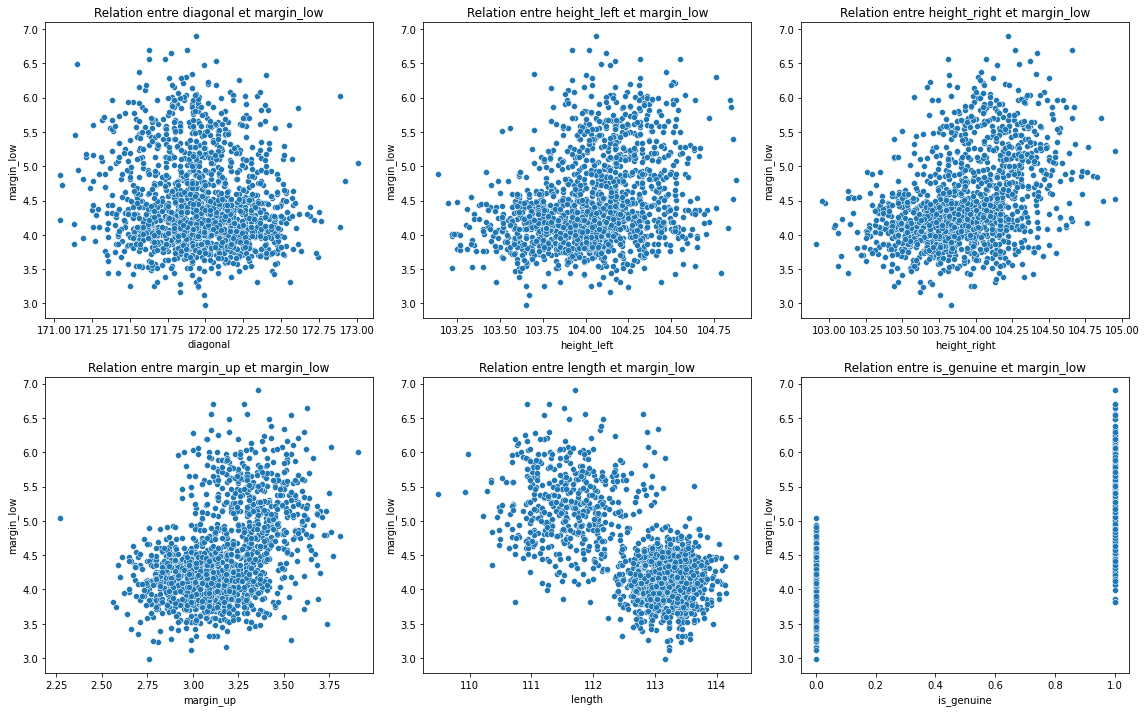

In [202]:
# Liste des variables prédictives
predictive_variables = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length', 'is_genuine']

# Déterminer le nombre de colonnes en fonction du nombre de variables prédictives
num_cols = min(len(predictive_variables), 3)
num_rows = (len(predictive_variables) + num_cols - 1) // num_cols

# Création de graphiques de dispersion pour chaque variable prédictive
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 10))

# Boucle sur les variables prédictives pour créer les graphiques
for i, variable in enumerate(predictive_variables):
    row = i // num_cols
    col = i % num_cols
    sns.scatterplot(x=df[variable], y=df['margin_low'], ax=axes[row, col])
    axes[row, col].set_title(f'Relation entre {variable} et margin_low')
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('margin_low')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

Les relations ne semblent linéaires à première vue, la dispertion des points est aléatoires.

La régression linéaire multiple est performante si la variable dépendante est fortement corrélés avec d'autres variables indépendantes. 
Examinons les corrélations entre nos différentes variables :

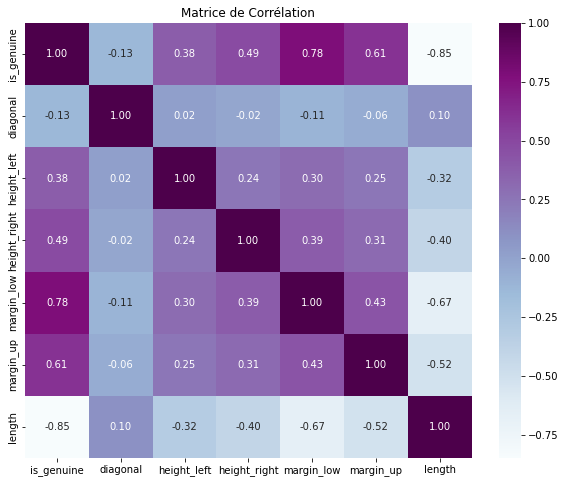

In [203]:
# On visualise la matrice de corrélations :

matrice_corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrice_corr, annot=True, fmt=".2f", cmap='BuPu')
plt.title("Matrice de Corrélation")
plt.show()

La variable "margin_low" semble corrélée positivement avec les variables "height_right", "height_left", "margin_up".</br>
Elle est aussi corrélée négativement avec les variables "length" et "is_genuine".</br>
Elle est très peu corélée à la variable "diagonal".</br>

***Globalement les corrélations ne sont pas faibles, ce qui est un bon signe pour l'imputation par régression.***

***Application du modèle aux données :***

In [204]:
# création d'un df sans les individus avec NaN dans margin_low (modèle d'apprentissage)

df_no_nan = df.dropna(subset=['margin_low'])

In [205]:
# isoler les NaN dans une variable (modèle de test)

df_nan = df[df['margin_low'].isna()]

In [206]:
# définition des variable X (regresseurs) et Y (variable à prédire)

X_train = df_no_nan.drop(columns=['margin_low'])  # Toutes les autres colonnes sont les features
y_train = df_no_nan['margin_low']

In [207]:
# Application du modèle aux données

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [208]:
df_no_nan.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [209]:
# utilisation de la fonction backward step pour selectionner les variables les plus pertinentes automatiquement

columns = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
reg_backward = backward_selected(df_no_nan[columns], 'margin_low')

_______________________________
margin_low ~ height_right + height_left + length + is_genuine + diagonal + margin_up + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_right + height_left + is_genuine + diagonal + margin_up + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_right + height_left + is_genuine + margin_up + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ height_left + is_genuine + margin_up + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

In [210]:
reg_multi = smf.ols('margin_low~margin_up, data=df_no_nan').fit()

***Analyse des résultats de la régression linéaire :***

analyse coeff durbin watson etc

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [211]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [212]:
n = df_no_nan.shape[0]
p = 6

In [213]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

- Calculez les leviers : 

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [214]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

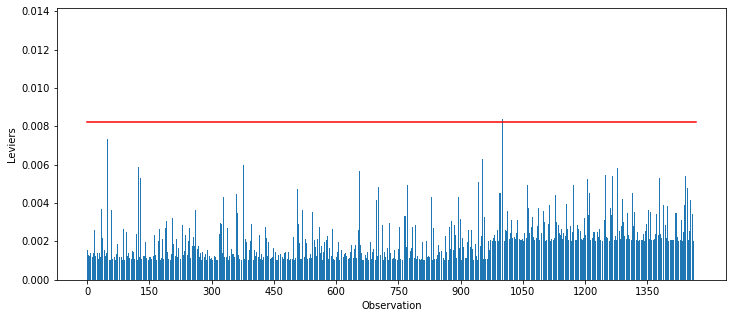

In [215]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1467, step=150))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1467], [seuil_levier, seuil_levier], color='r')

# plt.savefig(r"viz\leviers nan")

plt.show()

In [216]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
52,53,0.010647
649,650,0.013491
1000,1001,0.008380


- Calcul des résidus studentisés :

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [217]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

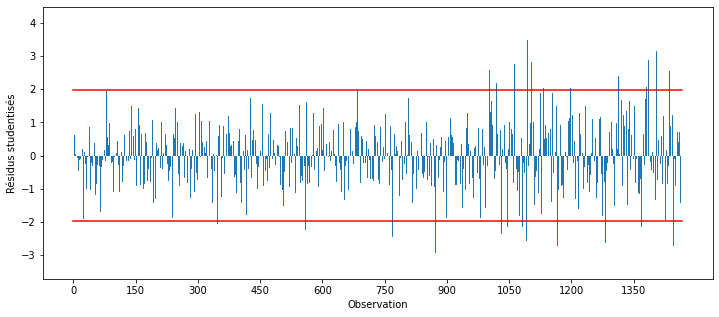

In [218]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1467, step=150))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1467], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1467], [-seuil_rstudent, -seuil_rstudent], color='r')

# plt.savefig(r"viz\résidus studentisés")

plt.show()

- Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [219]:
influence = reg_multi.get_influence().summary_frame()

In [220]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

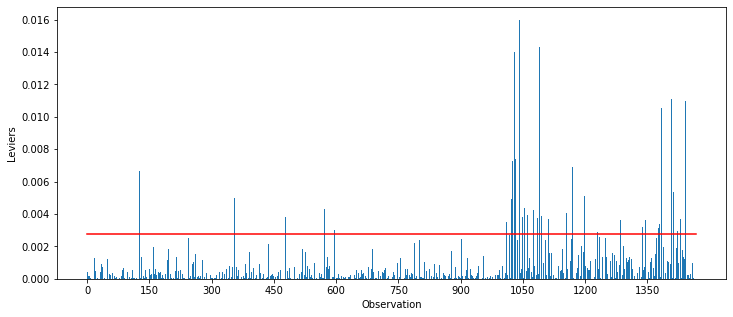

In [221]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1467, step=150))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1467], [seuil_dcook, seuil_dcook], color='r')

# plt.savefig(r"viz\distance de cook résidus")


plt.show()

In [222]:
# on isole les résidus
flag_residus = analyses.loc[analyses['dcooks'] > seuil_dcook, :]
flag_residus.shape

(93, 4)

In [223]:
index_residus = flag_residus.index
residus = df_no_nan.loc[index_residus]

In [224]:
residus.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
52,0,171.64,104.18,103.78,3.49,3.74,113.94
125,0,171.50,104.03,103.97,3.26,3.54,113.24
239,0,171.85,104.07,103.90,4.80,3.46,113.73


In [225]:
#perte d'infos en % si retrait 

prop_residus = (residus.shape[0] / df.shape[0]) * 100

print(f"{round(prop_residus, 2)}%")

6.2%


93 résidus, ce qui représente une proportion de 6.2% du jeu de données total

In [226]:
# retrait des résidus

df_cleaned = df_no_nan.drop(index=index_residus)
# df_cleaned.reset_index(drop=True, inplace=True)

In [227]:
df_cleaned.shape

(1370, 7)

In [228]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1370 non-null   int64  
 1   diagonal      1370 non-null   float64
 2   height_left   1370 non-null   float64
 3   height_right  1370 non-null   float64
 4   margin_low    1370 non-null   float64
 5   margin_up     1370 non-null   float64
 6   length        1370 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 85.6 KB


On applique le modele de regression sur notre df sans les résidus influents

In [229]:
reg_multi_clean = smf.ols('margin_low~margin_up+is_genuine', data=df_cleaned).fit()
print(reg_multi_clean.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1458.
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        10:14:50   Log-Likelihood:                -471.02
No. Observations:                1370   AIC:                             948.0
Df Residuals:                    1367   BIC:                             963.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7445      0.160     29.646      0.0

On remarque qu'après retrait des residus influents et application du modèle, on obtient : 
- un R² de 0.681 
- une AIC de 948

Le modèle est maintenant plus performant. Mais avant de valider l'utilisation de la régression linéaire, nous devons vérifier plusieurs hypothèses afin de s'assurer que nous pouvons appliquer cette régression. Voici les hypothèses à vérifier :

- Normalité : Les erreurs résiduelles doivent être distribuées normalement. Cela signifie que les résidus doivent suivre une distribution normale avec une moyenne de zéro.
- Homoscédasticité : L'homoscédasticité signifie que la variance des erreurs résiduelles est constante à tous les niveaux de la variable prédite.
- Multicolinéarité : Cette hypothèse concerne la relation entre les variables prédictives (ou indépendantes) dans notre modèle de régression. Elle stipule qu'il ne devrait pas y avoir de forte corrélation linéaire entre les variables indépendantes.


-------------------------------------

- **Testez la normalité des résidus**

Si l'on veut tester la normalité des résidus, on peut utiliser la droite de Henry et un test de Shapiro-Wilk.

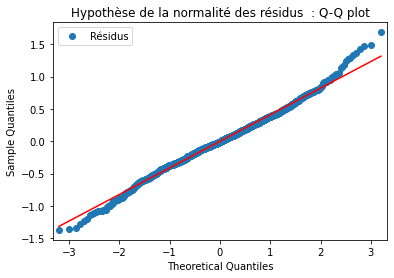

In [230]:
# droite de Henry

residuals = reg_multi.resid

sm.qqplot(residuals, line='s', label="Résidus")
plt.title("Hypothèse de la normalité des résidus  : Q-Q plot")
plt.legend()
plt.show()

In [231]:
# test de shapiro-wilk
 
shapiro(reg_multi_clean.resid)

ShapiroResult(statistic=0.9988514184951782, pvalue=0.5354368686676025)

Ici, l'hypothèse de normalité est validée (p-value > 0.05).

--------------------------

- **Testez l’homoscédasticité**

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [232]:
df_cleaned

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.52,2.89,112.83
1,0,171.46,103.36,103.66,3.77,2.99,113.09
2,0,172.69,104.48,103.50,4.40,2.94,113.16
3,0,171.36,103.91,103.94,3.62,3.01,113.51
4,0,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,1,171.75,104.38,104.17,4.42,3.09,111.28
1496,1,172.19,104.63,104.44,5.27,3.37,110.97
1497,1,171.80,104.01,104.12,5.51,3.36,111.95
1498,1,172.06,104.28,104.06,5.17,3.46,112.25


In [233]:
# Effectuer le test de Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(reg_multi_clean.resid, reg_multi_clean.model.exog)

# Afficher les résultats du test
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(lzip(labels, bp_test))

[('LM Statistic', 58.644525650768045), ('LM-Test p-value', 1.8429054654647829e-13), ('F-Statistic', 30.5664894579341), ('F-Test p-value', 1.031356245532465e-13)]


La p-valeur est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes.

--------------------------

- **Tester la multicolinéarité**

On calcule ensuite le Facteur d'Inflation de la Variance (VIF) qui est une mesure qui quantifie le degré de multicollinéarité dans un modèle de régression linéaire. </br>
Un VIF supérieur à 5 indique que les variables indépendantes sont fortement corrélées et peuvent donc ne pas fournir des estimations indépendantes.

In [234]:
X = df_cleaned[['is_genuine', 'margin_up']]
X = sm.add_constant(X)

# Calcul du VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

      feature         VIF
0       const  300.641644
1  is_genuine    1.602197
2   margin_up    1.602197


Ici, aucunes variables n'a un VIF > 5 

L'hypothèse de multicolinéarité est vérifiée.

--------------------------

***Prediction des 37 valeurs manquantes :***

In [235]:
# Préparation des données pour lesquelles 'margin_low' est NaN pour la prédiction

X_missing = df_nan[df_nan['margin_low'].isnull()].drop(columns=['margin_low'])

In [236]:
# Prédiction des valeurs manquantes
predicted_margin_low = model.predict(X_missing)

In [237]:
# on créé une Series avec les valeurs prédites, avec le meme index que notre df d'origine
predicted_margin_low_series = pd.Series(predicted_margin_low, index=X_missing.index)

In [238]:
# Remplissage des valeurs manquantes avec les prédictions
df_nan.loc[df_nan['margin_low'].isnull(), 'margin_low'] = predicted_margin_low_series

In [239]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     int64  
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    37 non-null     float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.3 KB


In [240]:
df_cleaned = pd.concat([df_cleaned, df_nan])
# Triez le DataFrame concaténé par index pour remettre les lignes à leur place d'origine
# df_cleaned = df_cleaned.reset_index(drop=True)

In [241]:
df_cleaned

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.520000,2.89,112.83
1,0,171.46,103.36,103.66,3.770000,2.99,113.09
2,0,172.69,104.48,103.50,4.400000,2.94,113.16
3,0,171.36,103.91,103.94,3.620000,3.01,113.51
4,0,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,1,172.17,104.49,103.76,5.302069,2.93,111.21
1315,1,172.08,104.15,104.17,5.200358,3.40,112.29
1347,1,171.72,104.46,104.12,5.175468,3.61,110.31
1435,1,172.66,104.33,104.41,5.173450,3.56,111.47


In [242]:
df_cleaned = df_cleaned.reset_index(drop=True)

In [243]:
df_cleaned.to_csv("df_cleaned.csv", index=False)

### Doublons

In [244]:
df_cleaned.duplicated().sum()

0

In [245]:
# Affichage des doublons

doublons = df_cleaned[df_cleaned.duplicated(subset=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'], keep=False)]
display(doublons)

# Calculer le nombre de doublons
nb_doublons = df_cleaned.duplicated(subset=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']).sum()
print(f"Nombre de variables avec doublons: {nb_doublons}")

# Calculer la proportion de doublons
prop_doublons = round((nb_doublons / len(df_cleaned)) * 100, 2)
print(f"Proportion de variables avec doublons: {prop_doublons}%")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Nombre de variables avec doublons: 0
Proportion de variables avec doublons: 0.0%


## 3. EDA

In [246]:
# Création d'un df avec les valeurs numériques, et un autre normalisé

df_num = df_cleaned.select_dtypes(float)

sc = StandardScaler()
df_norm = pd.DataFrame(sc.fit_transform(df_num), columns=df_num.columns, index=df_num.index)

In [247]:
palette_gen = {False: "#00BFFF", True: "#A901DB"}

### Analyse univariée

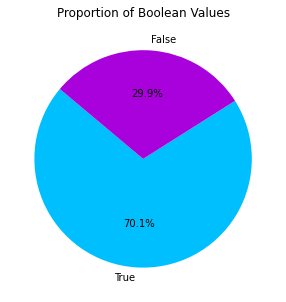

In [248]:
# affichage de la proportion de billets vrais et faux
values_gen = df_cleaned['is_genuine'].value_counts()

colors = [palette_gen[value] for value in values_gen.index]
plt.figure(facecolor='white', figsize=(5,5)) 
plt.pie(values_gen, labels=values_gen.index.map({1: 'False', 0: 'True'}), autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Boolean Values')
plt.show()

In [249]:
# nb  de billets
df_cleaned['is_genuine'].value_counts()

is_genuine
0    986
1    421
Name: count, dtype: int64

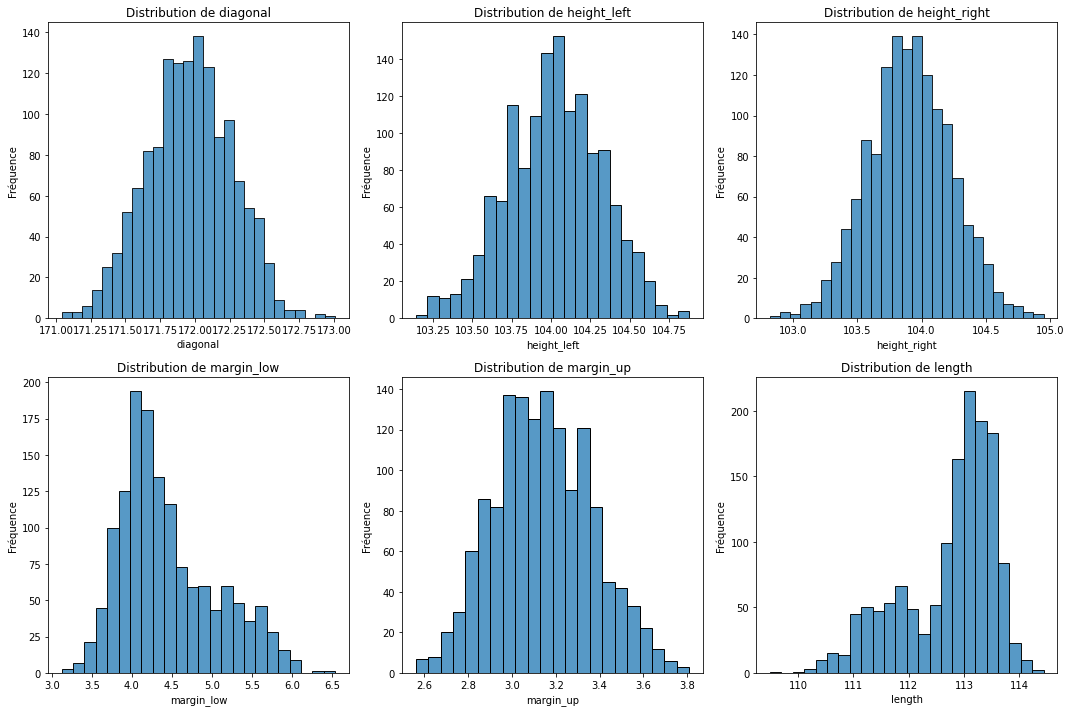

In [250]:
# affichages des histogramme des variables numériques pour étudier les distributions
n_cols = 3  

# Le nombre de lignes doit être basé sur le nombre de colonnes du DataFrame df_num
n_rows = (len(df_num.columns) + n_cols - 1) // n_cols  

# Créer une grille de subplots avec la taille correcte
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Parcourir chaque colonne numérique et créer un subplot
for i, column in enumerate(df_num.columns):
    ax = axes[i // n_cols, i % n_cols]
    sns.histplot(df_num[column], kde=False, ax=ax)
    ax.set_title(f'Distribution de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')

# Masquer les axes vides s'il y en a
for j in range(i + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].set_visible(False)

# Ajuster le layout pour éviter le chevauchement
plt.tight_layout()
plt.show()

Les distributions sont généralement symétriques pour la plupart des variables (diagonal, height_left, height_right, margin_up) et concentrées sur les valeurs centrale de l'axe des abcisses.

**- Variable margin_low** : la distribution est légèrement asymétrique vers la droite, avec une concentration des valeurs autour de 4. Légère queue longue à droite, montrant des valeurs plus élevées.

**- Variable margin_up** : la distribution est asymétriques à gauche, la plupart des valeurs se concentrent autour de 113.

<AxesSubplot:>

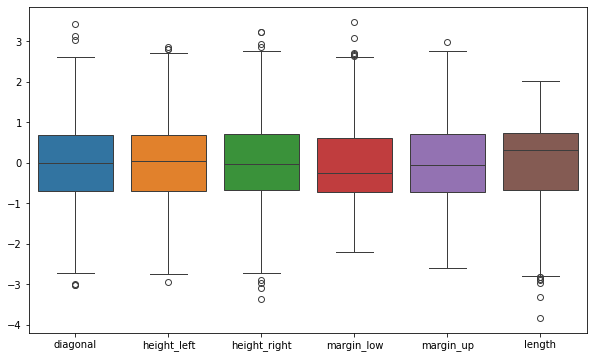

In [251]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_norm)

Quelques valeurs apparaissent comme étants des outliers sur ces boxplots.

Nous allons utiliser l'écart interquartile pour les identifier. Ils seront cependant conserver avant la regression logistique, car nous ne savons pas comment ils se comportent.

In [252]:
q1 = df_cleaned.loc[:, df_cleaned.columns != "is_genuine"].quantile(q=0.25, interpolation="midpoint")
q3 = df_cleaned.loc[:, df_cleaned.columns != "is_genuine"].quantile(q=0.75, interpolation="midpoint")
iq = q3 - q1

lim_outliers_inf = q1-1.5*iq
lim_outliers_sup = q3+1.5*iq

In [253]:
# Identifier les valeurs aberrantes
outliers = (df_cleaned.loc[:, df_cleaned.columns != "is_genuine"] < lim_outliers_inf) | (df_cleaned.loc[:, df_cleaned.columns != "is_genuine"] > lim_outliers_sup)

outliers_rows = outliers.any(axis=1)

df_outliers = df_cleaned[outliers_rows]

In [254]:
df_outliers

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.520000,2.89,112.83
171,0,171.75,103.63,102.97,4.460000,2.77,113.22
188,0,172.35,103.73,102.95,4.490000,3.37,112.49
282,0,172.09,103.14,103.81,4.880000,3.01,113.69
502,0,172.02,104.42,102.91,3.860000,3.12,113.43
702,0,171.04,103.84,103.64,4.220000,3.36,112.70
795,0,172.92,103.55,103.94,4.780000,3.27,113.55
809,0,172.89,103.77,104.24,4.120000,3.01,113.72
1001,1,172.02,104.43,104.37,5.590000,3.06,110.35
1007,1,171.87,104.16,104.44,6.040000,3.32,111.99


### Analyse bivariée

In [255]:
# On calcule la différence de diagonale entre les vrais et les faux billets
diff_diag = (((df_cleaned.loc[df_cleaned["is_genuine"]==True]["diagonal"].mean())-(df_cleaned.loc[df_cleaned["is_genuine"]==False]["diagonal"].mean()))/(df_cleaned.loc[df_cleaned["is_genuine"]==True]["diagonal"].mean()))*100

# On calcule la différence de hauteur entre les vrais et les faux billets
diff_h_left = (((df_cleaned.loc[df_cleaned["is_genuine"]==True]["height_left"].mean())-(df_cleaned.loc[df_cleaned["is_genuine"]==False]["height_left"].mean()))/(df_cleaned.loc[df_cleaned["is_genuine"]==True]["height_left"].mean()))*100
diff_h_right = (((df_cleaned.loc[df_cleaned["is_genuine"]==True]["height_right"].mean())-(df_cleaned.loc[df_cleaned["is_genuine"]==False]["height_right"].mean()))/(df_cleaned.loc[df_cleaned["is_genuine"]==True]["height_right"].mean()))*100

# On calcule la différence de marge entre les vrais et les faux billets
diff_m_low = (((df_cleaned.loc[df_cleaned["is_genuine"]==True]["margin_low"].mean())-(df_cleaned.loc[df_cleaned["is_genuine"]==False]["margin_low"].mean()))/(df_cleaned.loc[df_cleaned["is_genuine"]==True]["margin_low"].mean()))*100
diff_m_up = (((df_cleaned.loc[df_cleaned["is_genuine"]==True]["margin_up"].mean())-(df_cleaned.loc[df_cleaned["is_genuine"]==False]["margin_up"].mean()))/(df_cleaned.loc[df_cleaned["is_genuine"]==True]["margin_up"].mean()))*100

# On calcule la différence de longeur entre les vrais et les faux billets
diff_length = (((df_cleaned.loc[df_cleaned["is_genuine"]==True]["length"].mean())-(df_cleaned.loc[df_cleaned["is_genuine"]==False]["length"].mean()))/df_cleaned.loc[df_cleaned["is_genuine"]==True]["length"].mean())*100

# Affichage des résultats sous forme de Tableau
pd.DataFrame(index=["Moyenne des écarts en %"],columns=["diagonale","height_left","height_right","margin_low","margin_up","length"],data=[[diff_diag, diff_h_left, diff_h_right, diff_m_low, diff_m_up, diff_length]])

,diagonale,height_left,height_right,margin_low,margin_up,length
Moyenne des écarts en %,-0.05369,0.22775,0.321359,20.82935,8.875325,-1.407973


En comparant les données ci-dessus, on constate que :

- Diagonale : La différence moyenne en pourcentage de la diagonale entre les vrais et les faux billets est très faible (0.05%). Cela suggère que la diagonale des billets n'est pas un bon indicateur pour distinguer les vrais des faux billets.
- Hauteur gauche et droite : Les différences moyennes en pourcentage de la hauteur gauche et de la hauteur droite entre les vrais et les faux billets sont également assez faibles.
- Marge inférieure et supérieure : On observe une différence plus significative pour la marge inférieure, avec une moyenne de 20.83%. Cela suggère qu'il y a une différence notable dans la marge inférieure entre les vrais et les faux billets, ce qui pourrait être un indicateur utile pour la détection de contrefaçons. Pour la marge supérieure, bien que la différence moyenne en pourcentage soit moins importante (8.88%), elle reste significative.
- Longueur : La différence moyenne en pourcentage de la longueur entre les vrais et les faux billets est faible (-1.41%).

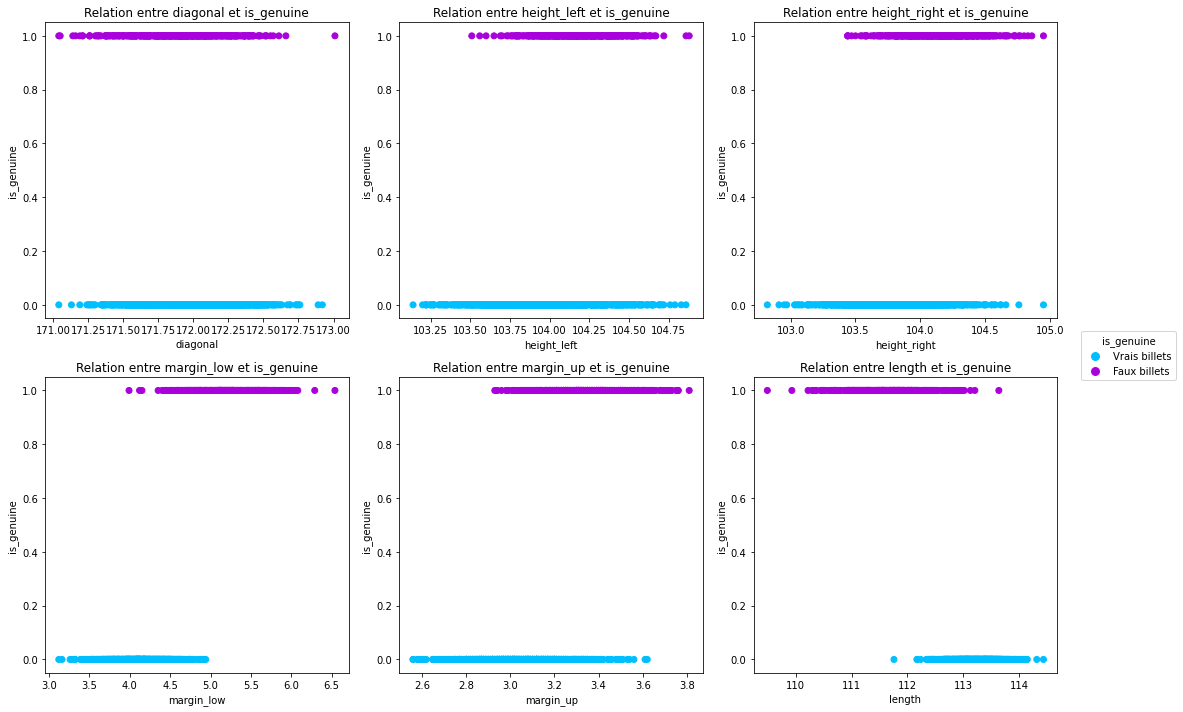

In [256]:
#scatter plot pour analyse des relations

col = df_cleaned.drop(columns='is_genuine')

n_cols = 3
n_rows = (len(col.columns) + n_cols - 1) // n_cols

# Créer une grille de subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

i = 0  # Initialiser le compteur
for var in col.columns:
    ax = axes[i // n_cols, i % n_cols]  # Trouver la position correcte dans la grille
    
    # Créer une liste de couleurs pour chaque point
    colors = [palette_gen[bool(val)] for val in df_cleaned['is_genuine']]
    
    # Utiliser la liste de couleurs pour la coloration des points
    ax.scatter(y=df_cleaned['is_genuine'], x=df_cleaned[var], c=colors)
    
    ax.set_title(f'Relation entre {var} et is_genuine')
    ax.set_xlabel(var)
    ax.set_ylabel('is_genuine')
    i += 1  # Incrémenter le compteur après chaque itération

# Masquer les axes vides s'il y en a
for j in range(i, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].set_visible(False)

# Ajouter la légende
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in palette_gen.values()]
labels = ['Faux billets' if key else 'Vrais billets' for key in palette_gen.keys()]
fig.legend(handles, labels, loc='center left', title='is_genuine', bbox_to_anchor=(1, 0.5))   

# Ajuster le layout pour éviter le chevauchement
plt.tight_layout()
plt.show()

On remarque que pour la variable length, les valeurs "false" (en violet) sont principalement dans l'intervalle de valeurs [110;113], alors que les valeurs "true" sont elles dans l'intervale [112.5;114]
=> un billet qui à une longueur de 111mm aura plus de probabilité d'être un faux billet.

On peut observer une tendance similaire avec la variable margin_low.

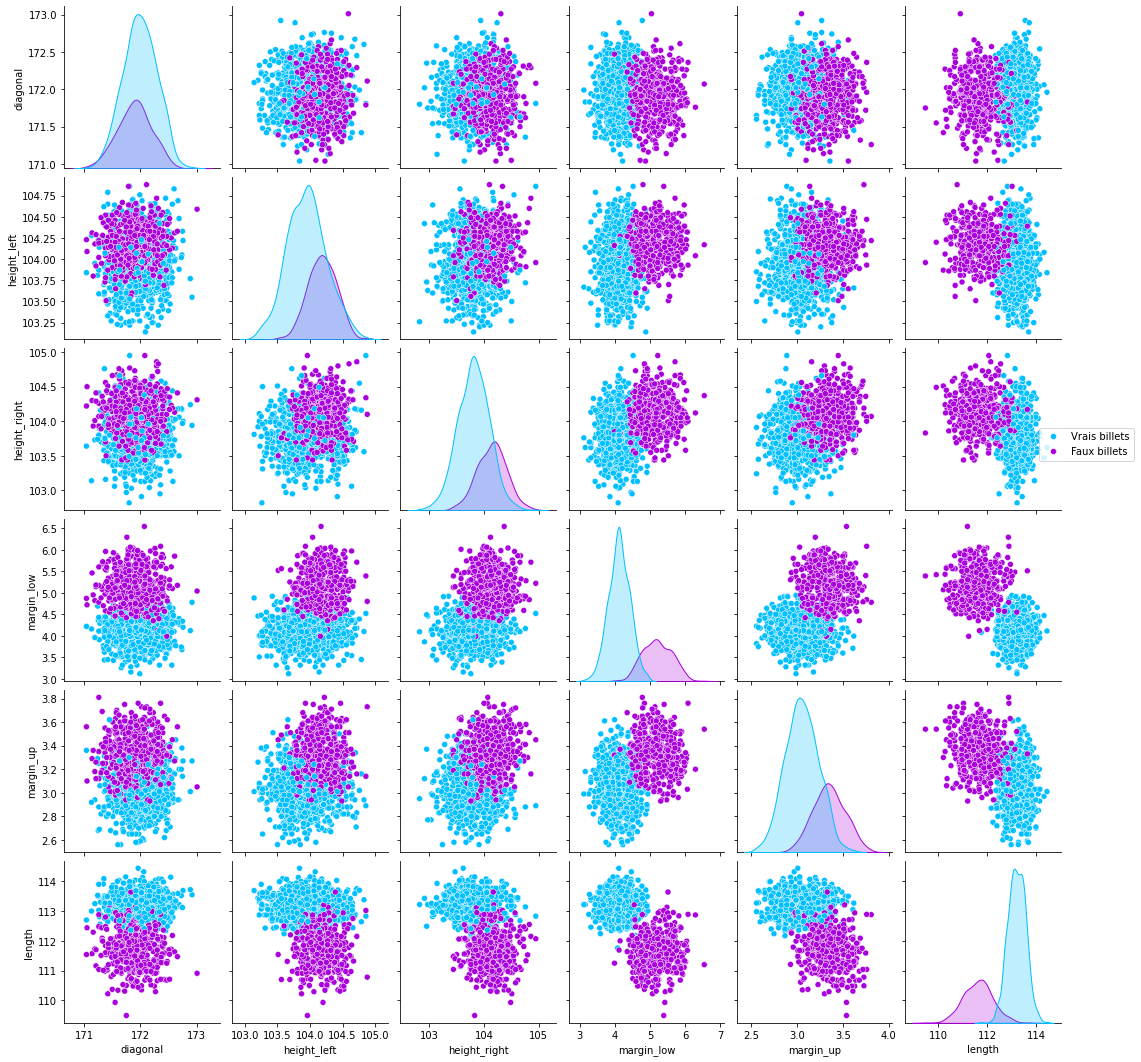

In [257]:
# analyse des relations à travers un pairplot
custom_labels = {True: 'Faux billets', False: 'Vrais billets'}

pairplot = sns.pairplot(df_cleaned, hue='is_genuine', palette=palette_gen)

handles, labels = pairplot._legend_data.values(), pairplot._legend_data.keys()

# Remplacer les labels avec les intitulés personnalisés
custom_labels_list = [custom_labels[label == '0'] if label in custom_labels else custom_labels[label == '1'] for label in labels]

# Ajouter la légende personnalisée
pairplot._legend.remove()  # Supprimer la légende par défaut
pairplot.fig.legend(handles, custom_labels_list, loc='upper right', bbox_to_anchor=(1, 0.6))


Plusieurs infos sont à relever de ce pairplot :

- Comme vu sur le précédent graph, les classes pour les variables "margin_low" et "length" sont bien distinctes sur les histogrammes
- Pour la plupart des variables, les classes formes des groupes distincts sur les nuages de points

In [258]:
# cross tab

for i in df_cleaned.drop(columns=['is_genuine']).columns:

    binned_column = pd.cut(df_cleaned[i], bins=3)
    
    # Créer un crosstab entre 'is_genuine' et la colonne discrétisée
    crosstab = pd.crosstab(df_cleaned['is_genuine'], binned_column)
    
    # Afficher le nom de la colonne et le crosstab correspondant
    print(f"Crosstab for {i}:")
    print(crosstab)
    print("\n")

Crosstab for diagonal:
diagonal    (171.038, 171.697]  (171.697, 172.353]  (172.353, 173.01]
is_genuine                                                           
0                          172                 696                118
1                          109                 280                 32


Crosstab for height_left:
height_left  (103.138, 103.72]  (103.72, 104.3]  (104.3, 104.88]
is_genuine                                                      
0                          228              634              124
1                            6              285              130


Crosstab for height_right:
height_right  (102.818, 103.53]  (103.53, 104.24]  (104.24, 104.95]
is_genuine                                                         
0                           175               753                58
1                             5               270               146


Crosstab for margin_low:
margin_low  (3.117, 4.26]  (4.26, 5.4]  (5.4, 6.54]
is_genuine                   

Un tableau croisé nous permet de visualiser la distribution des valeurs de la classe is_genuine selon des intervalles de valeurs des autres variables.

In [259]:
# test de kuskal-wallis pour comprendre la relation entre l'authenticité d'un billet (variable is_genuine) et l'ensemble de nos variables quantitatives 

columns_num = df_num.columns

# Initialisation d'un DataFrame pour les résultats avec les noms de colonnes corrects
results = pd.DataFrame(columns=["variable", "Kruskal-Wallis", "P_value"])

# Boucle sur chaque variable numérique et exécution du test de Kruskal-Wallis
for var in columns_num:
    # Regrouper les données selon la catégorie 'is_genuine'
    groups = [group[var].dropna().values for name, group in df_cleaned.groupby('is_genuine')]
    # Effectuer le test de Kruskal-Wallis
    kruskal_test = kruskal(*groups)
    # Ajouter les résultats au DataFrame
    new_row = pd.DataFrame({"variable": [var], "Kruskal-Wallis": [kruskal_test.statistic], "P_value": [kruskal_test.pvalue]})
    results = pd.concat([results, new_row], ignore_index=True)

# Trier les résultats par la colonne 'P_value' en ordre croissant
results_sorted = results.sort_values(by="P_value", ascending=True)

# Afficher les résultats
print(results_sorted)

       variable  Kruskal-Wallis        P_value
5        length      837.831644  3.213772e-184
3    margin_low      835.576995  9.935497e-184
4     margin_up      514.228860  7.623304e-114
2  height_right      323.466609   2.545723e-72
1   height_left      204.774991   1.896189e-46
0      diagonal       24.937996   5.920400e-07


Toutes les variables ont une p_value < 0.05 : elles sont donc toutes significatives.

Les variables length, margin_low et margin_up sont les plus significatives pour déterminer l'authenticité d'un billet.

# Modèle de prédiction

Pour prédire si un billet et vrai ou faux, nous allons tester 2 modèles et retenir le plus performant des deux :

- K-Means
- LogisticRegression

# K-Means

*Test d'un modele de clustering non supervisé*

On commence par une ACP pour pouvoir visualiser plus tard notre kmeans sous forme de nuage de points

In [260]:
df_acp = df_cleaned.drop(columns=['is_genuine']) 

acp_km = PCA(n_components=6).fit(df_acp)

In [261]:
# % de variance expliqué pour chaque variable
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : acp_km.explained_variance_,
        "% variance expliquée" : np.round(acp_km.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(acp_km.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,0.978614,69.0,69.0
1,Dim2,0.149332,11.0,80.0
2,Dim3,0.096747,7.0,87.0
3,Dim4,0.082804,6.0,92.0
4,Dim5,0.073332,5.0,98.0
5,Dim6,0.034334,2.0,100.0


In [262]:
pca = PCA(n_components=2).fit(df_acp)
xk_projected = pca.transform(df_acp)

In [263]:
# Transformation en DataFrame pandas

df_pca = pd.DataFrame({
    "Dim1" : xk_projected[:,0], 
    "Dim2" : xk_projected[:,1],
    "is_genuine" : df_cleaned["is_genuine"]
})

df_pca.sample(5)

,Dim1,Dim2,is_genuine
32,-0.124923,0.222366,0
839,-0.987963,-0.036658,0
72,-0.742342,-0.383591,0
1142,1.067227,-0.169754,1
235,-0.616986,-0.800257,0


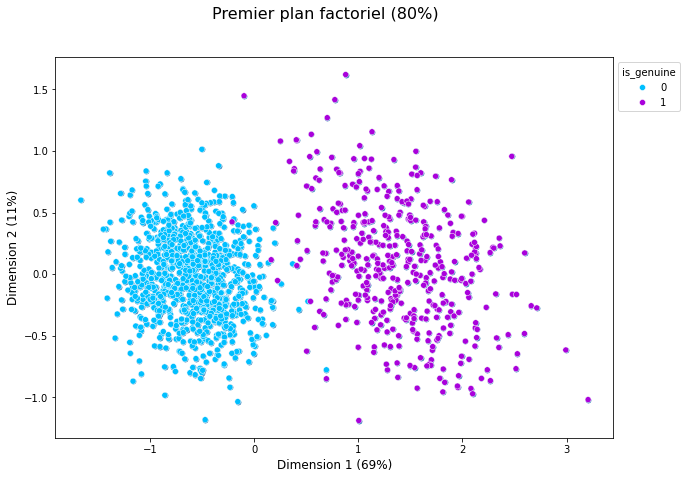

In [264]:
# visualisation du 1er plan factoriel 

fig, ax = plt.subplots(figsize=(10, 7))
df_pca.plot.scatter("Dim1", "Dim2", ax = ax) 

scatter = df_pca.plot.scatter("Dim1", "Dim2", ax=ax)

plt.xlabel("Dimension 1 (69%)", fontsize=12) 
plt.ylabel("Dimension 2 (11%)", fontsize=12)
plt.suptitle("Premier plan factoriel (80%)", fontsize=16)

#associer une couleur par continent
sns.scatterplot(data=df_pca, x="Dim1", y="Dim2", hue="is_genuine", palette=palette_gen, ax=scatter)
plt.legend(title="is_genuine", bbox_to_anchor=(1, 1), loc='upper left')

# plt.savefig(
    # r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\premier plan factoriel avec continents.png",
# )

plt.show()

Naturellement, les classes sont plutot bien séparées sur le nuage de point.

**Application du KMeans**

In [265]:
# définition des variables explicatives et de la variable d'intérêt 

X = df_pca.drop(columns=['is_genuine'])
y = df_pca['is_genuine']

In [266]:
#split du dataset en ensemble d'apprentissage et de test 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Le nombre de clusters sera de 2 car nous cherchons à classifier nos données en 2 groupes distincts :  les vrais des faux billets

In [267]:
# Nous définissons 2 clusters pour notre modèle et entrainons le sur le jeu d'entrainement
model_km = KMeans(n_clusters=2, init='k-means++')
km=model_km.fit(X_train)

In [268]:
#ajout d'une colonne au datset d'entrainement pour afficher les clusters

cluster_km = km.labels_

In [269]:
# On réalise notre prediction que l'on va stocker dans une variable
prediction = model_km.predict(X_test)

In [270]:
# On créé une colonne dans notre table en ajoutant les labels calculé par le model
X_test["Cluster_km"] = prediction

In [271]:
# ajout des centroids
centroids_km = km.cluster_centers_
# centroids_km_projected = acp_km.transform(centroids_km)

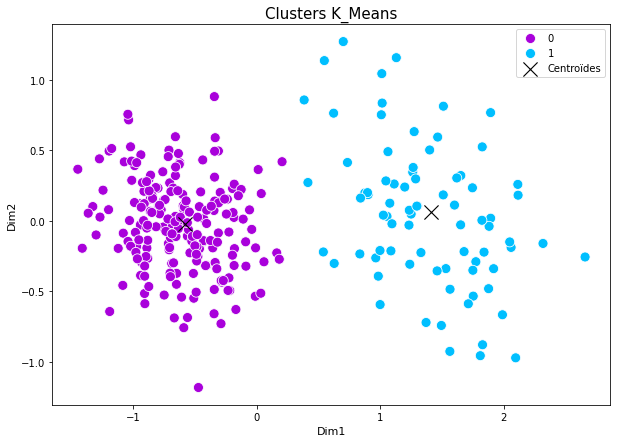

In [272]:
palette_bin = {0: "#00BFFF", 1: "#A901DB"}

plt.figure(figsize=(10, 7))
sns.scatterplot(data=X_test, x='Dim1', y='Dim2', hue='Cluster_km', palette=palette_bin, s=100, markers=['o', 's'])
sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:, 1], color='black', marker='x', s=200, label='Centroïdes')

plt.title('Clusters K_Means', fontsize=15)
plt.xlabel('Dim1', fontsize=11)
plt.ylabel('Dim2', fontsize=11)
plt.legend(title='')

plt.show()

In [273]:
# affichage de l'inertie, qui est une mesure de dispertion des points autour de leur centroides
 
print('Inertie totale :',km.inertia_)

Inertie totale : 342.80402887724006


Plus l'inertie est faible, plus les points à l'intérieur de chaque cluster sont proches les uns des autres et plus les clusters sont compacts.
Une faible inertie indique donc que les clusters sont bien séparés et que l'algorithme a trouvé une bonne configuration de clusters pour les données.



In [274]:
silhouette_score(X_test,prediction)

0.709348131697865

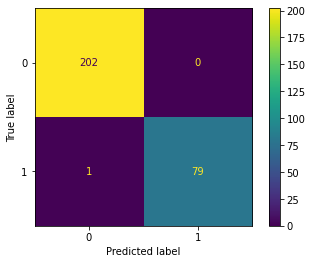

In [275]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Dans notre jeu de donnée test :

- 202 vrais billets
- 80 faux billets

202 vrais billets ont été identifiés par le modele
79 faux billets
1 billet a été classé comme "Vrai" par le modèle, alors qu'il était en réalité faux (faux négatif).

In [276]:
score = f1_score(y_test, X_test["Cluster_km"])
if score <0.5:
    X_test["Cluster_km"].replace([0,1], [1,0], inplace=True)
    score = f1_score(y_test, X_test["Cluster_km"])
    print("Le F1 score est de:",score)
else : 
    print("Le F1 score est de:",score)

Le F1 score est de: 0.9937106918238994


En conclusion, notre kmeans est trés performant : il a obtenu un F1 score de 0.9937 sur le jeu de données test. Sur les 282 valeurs de notre dataset de test, un seul faux négatif a été prédit.

## Régression logistique

*Test d'un modèle de classification supervisé*

L'objectif est d'expliquer une variable qualitative binaire (Vrai/faux) par des variables aléatoires quantitatives.

In [277]:
df_cleaned.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.52,2.89,112.83
1,0,171.46,103.36,103.66,3.77,2.99,113.09
2,0,172.69,104.48,103.50,4.40,2.94,113.16
3,0,171.36,103.91,103.94,3.62,3.01,113.51
4,0,171.73,104.28,103.46,4.04,3.48,112.54


In [278]:
# standardisation des données pour mettre les données à la meme echelle et éviter les biais

col = ['diagonal', 'height_left', 'height_right', 'margin_low',	'margin_up', 'length']

# df_cleaned[col] = sc.fit_transform(df_cleaned[col])

In [279]:
df_cleaned

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.520000,2.89,112.83
1,0,171.46,103.36,103.66,3.770000,2.99,113.09
2,0,172.69,104.48,103.50,4.400000,2.94,113.16
3,0,171.36,103.91,103.94,3.620000,3.01,113.51
4,0,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1402,1,172.17,104.49,103.76,5.302069,2.93,111.21
1403,1,172.08,104.15,104.17,5.200358,3.40,112.29
1404,1,171.72,104.46,104.12,5.175468,3.61,110.31
1405,1,172.66,104.33,104.41,5.173450,3.56,111.47


**Séparation du jeu de données**

La fonction train_test_split divise les données en un ensemble d'entraînement (80% des données) et un ensemble de test (20% des données), ce qui est défini par test_size=0.2. 
L'argument random_state=42 garantit que la séparation est reproductible; les mêmes données seront divisées de la même manière à chaque exécution.8

In [280]:
# définition des variables explicatives et de la variable d'intérêt 
X = df_cleaned.drop(columns=['is_genuine'])
y = df_cleaned['is_genuine']

In [281]:
# Ajout d'une constante pour l'interception
X = sm.add_constant(X)

In [282]:
#split du dataset en ensemble d'apprentissage et de test 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [283]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [284]:
X_train.shape

(1125, 7)

In [285]:
X_test.shape

(282, 7)

In [286]:
# création du modèle 
logit_model = sm.Logit(y_train, X_train)

In [287]:
res_log = logit_model.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.008930
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1118
Method:                           MLE   Df Model:                            6
Date:                Mon, 27 May 2024   Pseudo R-squ.:                  0.9854
Time:                        10:15:06   Log-Likelihood:                -10.046
converged:                       True   LL-Null:                       -690.16
Covariance Type:            nonrobust   LLR p-value:                9.884e-291
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          481.8112    636.295      0.757      0.449    -765.305    1728.927
diagonal        -1.076

In [288]:
# on ne garde que les variables significatives à alpha = 5%

X = df_cleaned.drop(columns=['is_genuine', 'diagonal', 'height_right', 'height_left' ])
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

logit_model = sm.Logit(y_train, X_train)

reg_log = logit_model.fit()

print(reg_log.summary())

Optimization terminated successfully.
         Current function value: 0.010667
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 May 2024   Pseudo R-squ.:                  0.9826
Time:                        10:15:06   Log-Likelihood:                -12.000
converged:                       True   LL-Null:                       -690.16
Covariance Type:            nonrobust   LLR p-value:                8.843e-294
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        781.9292    189.655      4.123      0.000     410.212    1153.646
margin_low    13.1513      3

Le warning est dû au fait que le modèle apprend "trop bien", il y a des variables qui prédisent parfaitement y, ce n'est pas réaliste, cela vient du fait que nos données sont très artificielles, il y a donc peu d'erreur.

14 itérations pour stabiliser les coeff et ajustement

- LLR p-value est inférieure à 0.05, le modèle est significatif dans son ensemble.
- Le pseudo R² est très proche de 1, notre modèle explique donc la majorité de la variance observée.
- Les coefficients indiquent l'effet des variables sur la probabilité logarithmique d'appartenance à une certaine classe (ici, vrais ou faux billets)
- Selon les p-values, toutes les variables sont significatives

In [289]:
# Test de Wald:
print("avant élimination des variables non-significatives:\n", res_log.wald_test_terms())
print("après élimination des variables non-significatives:\n", reg_log.wald_test_terms())

avant élimination des variables non-significatives:
                                  chi2                 P>chi2  df constraint
const          [[0.5733714195858194]]     0.4489223056871102              1
diagonal       [[0.1960026125260181]]     0.6579669556429228              1
height_left   [[0.08878936881615253]]     0.7657219010180046              1
height_right   [[1.3761934033051288]]    0.24075061487809868              1
margin_low      [[9.793942183169282]]  0.0017508770123318184              1
margin_up       [[6.544551636694658]]   0.010520583826182015              1
length         [[16.118665952340063]]  5.949475027590898e-05              1
après élimination des variables non-significatives:
                               chi2                  P>chi2  df constraint
const       [[16.998299434732793]]  3.7413312734116716e-05              1
margin_low  [[11.109248420649777]]   0.0008589829405099854              1
margin_up   [[6.8185402232766466]]    0.009021628078638946      

Le test de Wald nous permet de confirmer que nous avons conserver que les variables significatives

In [290]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 const         42701.695452
margin_low        1.936100
margin_up         1.417046
length            2.130076
dtype: float64
VIF moyen: 10676.794668234357


Ici, aucunes variables n'a un VIF > 5 

L'hypothèse H0 est vérifiée : il n'y a pas de multicollinéarité entre les variables indépendantes.

--------------------------

In [291]:
# Linéarité des logits

# ajout des termes quadratiques

X_train_sq = X_train**2
X_test_sq = X_test**2

logit_model = sm.Logit(y_train, X_train_sq)


In [292]:
res_log_sq = logit_model.fit()

# Resume des resultats:
print(res_log_sq.summary())

Optimization terminated successfully.
         Current function value: 0.010648
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 May 2024   Pseudo R-squ.:                  0.9826
Time:                        10:15:06   Log-Likelihood:                -11.979
converged:                       True   LL-Null:                       -690.16
Covariance Type:            nonrobust   LLR p-value:                8.658e-294
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        385.1154     93.863      4.103      0.000     201.148     569.083
margin_low     1.4406      0

Le Log-Likelihood s'est légèrement amélioré (-12.000 à -11.979), ce qui indique une très légère amélioration du modèle.

Le Pseudo R-squared reste identique (0.9826), ce qui signifie que la proportion de la variance expliquée par le modèle n'a pas changé de manière significative.

Les valeurs des coefficients ont toutes diminué, ce qui peut indiquer que l'ajout des termes quadratiques a réduit l'impact des valeurs initiales des variables.


**En résumé, l'ajout des termes quadratiques a permis de mieux capturer la complexité des relations entre vos variables explicatives et la variable dépendante, même si l'amélioration globale du modèle reste légère.**


--------------------------

## Evaluation du modèle 

In [293]:
y_pred = (reg_log.predict(X_test) > 0.5).astype(int)

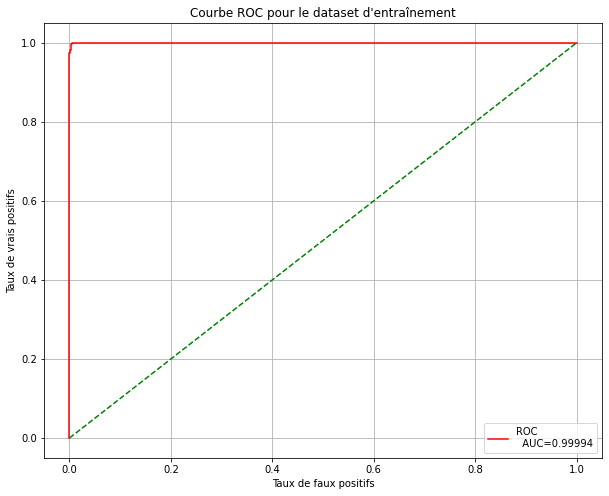

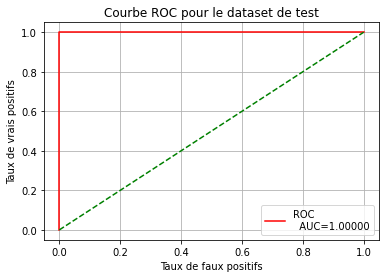

In [294]:
def plot_roc_curve(fp1, tp1, dataset_name):
    aucf = metrics.auc(fp1, tp1)
    plt.plot(fp1, tp1, color='red', label='ROC'+ "\n"'  AUC=%1.5f' % aucf)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--',)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC pour le dataset ' + dataset_name)
    plt.grid(True)
    plt.legend()
    plt.show()

# obtenir les prédictions du modèle sur le dataset de train et de test
y_train_pred = reg_log.predict(X_train)
y_test_pred = reg_log.predict(X_test)

# calcul des courbes ROC pour train et test
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

# tracage des courbes ROC pour train et test
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_train, tpr_train, "d'entraînement")
plot_roc_curve(fpr_test, tpr_test, "de test")


In [295]:
# On vérifie le score de notre model sur les données Test (F1 score)

f1_score_logit = f1_score(y_test, y_pred)
accuracy_logit = accuracy_score(y_test, y_pred)

# Afficher le score F1
print("Score F1 de la régression logistique sur les données de test:", f1_score_logit.round(3))
print("Exactitude de la régression logistique sur les données de test:", accuracy_logit)

Score F1 de la régression logistique sur les données de test: 0.994
Exactitude de la régression logistique sur les données de test: 0.9964539007092199


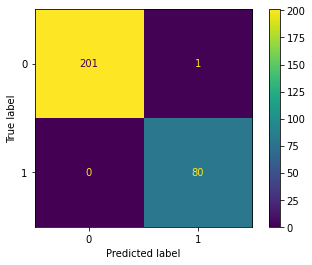

In [296]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Pour rappel: 

282 billets dans notre dataset de test.

- 201 vrai négatifs
- 0 faux négatif
- 80 vrais positifs
- 1 faux positif

En conclusion, notre modèle de regression logistique est trés performant : sur les 282 valeurs de notre dataset de test, un seul faux positif a été prédit.

In [297]:
# enregistrement du model
pickle.dump(reg_log, open("reg_log.pkl", "wb"))

# Prediction sur fichier de test

In [298]:
X_test = billets_test[["margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)

In [299]:
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [300]:
billets_test["proba"] = reg_log.predict(X_test_sc)
billets_test["y_pred"] = (reg_log.predict(X_test_sc) >= 0.5).astype(int)
print(billets_test[["id","proba","y_pred"]])

    id     proba  y_pred
0  B_1  0.000033       0
1  B_2  1.000000       1
2  B_3  0.000003       0
3  B_4  1.000000       1
4  B_5  0.999999       1
